In [1]:
#!pip install cuda
#!pip install torch.cuda
# https://www.kaggle.com/emmarex/cassava-disease-classification-2/data (코드)
#https://www.kaggle.com/fuxungao/cassava-disease-classification-baseline

In [2]:
%matplotlib inline 
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
import os
from torchvision import datasets, transforms, models
from PIL import Image
from os import listdir
import pandas as pd
import os
import gc
print(os.listdir("cassava"))

['random.txt', 'sample_submission_file.csv', 'test', 'train']


In [3]:
random_seed=1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
print(os.getcwd()) # 현재 해당 경로

C:\Users\dmsgh\NLP


## OS 모듈
### 학습 데이터 클래스와 개수 구하기

In [5]:
l=[]
for i in os.listdir('cassava/train/train'):
    print(i+':',len(os.listdir(os.path.join('cassava/train/train',i)))) # 데이터 개수
    l.append(i)

cbb: 466
cbsd: 1443
cgm: 773
cmd: 2658
healthy: 316


In [6]:
print(l) # 클래스는 5개

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [7]:
data_directory = 'cassava/train/train'
epochs = 100


## 데이터 loading
### Original 데이터 살펴보기

In [8]:
def load_image(path):
    img=Image.open(path)
    return img

def load_data(path):
    images=[]
    labels=[]
    
    i=0
    for cassava in os.listdir(path):
        cassava_path=os.path.join(path,cassava)
        num_imgs_Id=0
        for image in os.listdir(cassava_path): # 클래스별로 파일 순회
            image_path=os.path.join(cassava_path, image)
            img=load_image(image_path)
            print(img)
            images.append(img)
            labels.append(i)
load_data(data_directory)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC2BC588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x500 at 0x209FC2FD908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC2FD978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC2FDC50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC2FDCC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC2FDD30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC2FDDA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC2FDE10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC2FDE80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC2FDEF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC2FDF60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC2FDFD0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC37FE80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC37FEF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC37FF60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FC37FFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FC355080>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC3550F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC355160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC3551D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC355240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC3552B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=476x500 at 0x209FC355320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x500 at 0x209FC355390>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC3DAF60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC3DAFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC407048>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC4070F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC407160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC4071D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC407240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FC4072B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC407320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC407390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC407400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC407470>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC471630>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC4716A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC471710>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC471780>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC4717F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC471860>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=704x500 at 0x209FC4718D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC471940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC4719B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC471A20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC471A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC471B00>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC5500B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC550128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FC550198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FC550208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC550278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=676x500 at 0x209FC5502E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC550358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC5503C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x500 at 0x209FC550438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC5504A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC550518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC550588>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC5B5668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FC5B56D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC5B5748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC5B57B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC5B5828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC5B5898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC5B5908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC5B5978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x648 at 0x209FC5B59E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=549x500 at 0x209FC5B5A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC5B5AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC5B5B38>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC6445F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC644668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC6446D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC644748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC6447B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC644828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FC644898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FC644908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC644978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FC6449E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x500 at 0x209FC644A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=684x500 at 0x209FC644AC8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD6BF748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=548x500 at 0x209FD6BF7F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD6BF860>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD6BF8D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FD6BF940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD6BF9B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=658x500 at 0x209FD6BFA20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD6BFA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD6BFB00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD6BFB70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD6BFBE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD6BFC50>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD723FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=613x500 at 0x209FD746080>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7460F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD746160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7461D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD746240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7462B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD746320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD746390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD746400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD746470>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7464E0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B1550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7B15C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7B1630>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x619 at 0x209FD7B16A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B1710>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD7B1780>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7B17F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B1860>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B18D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD7B1940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B19B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD7B1A20>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD814B00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD814B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD814BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD814C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD814CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD814D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD814DA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD814E10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FD814E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD814EF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=549x500 at 0x209FD814F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD814FD0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x557 at 0x209FD8A25C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=804x500 at 0x209FD8A2630>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FD8A26A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD8A2710>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x500 at 0x209FD8A2780>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD8A27F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD8A2860>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD8A28D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD8A2940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD8A29B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FD8A2A20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD8A2A90>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC27C7F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD970A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD970B00>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD970B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD970BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=559x500 at 0x209FD970C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD970CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD970D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD970DA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FD970E10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD970E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD970EF0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9D7BE0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD9D7C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9D7CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD9D7D30>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9D7DA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD9D7E10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9D7E80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9D7EF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FD9D7F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD9D7FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9F6080>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FD9F60F0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x694 at 0x209FDA32B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x889 at 0x209FDA32BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=563x500 at 0x209FDA32C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FDA32C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=719x500 at 0x209FDA32D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32E48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDA32EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32F28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDA32F98>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDABC2E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x630 at 0x209FDABC358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x525 at 0x209FDABC3C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FDABC438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDABC4A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDABC518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=622x500 at 0x209FDABC588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FDABC5F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDABC668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=641x500 at 0x209FDABC6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x701 at 0x209FDABC748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FDABC7B8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=842x500 at 0x209FDB207B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB20828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x630 at 0x209FDB20898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB20908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB20978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB209E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=886x500 at 0x209FDB20A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB20AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x521 at 0x209FDB20B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=514x500 at 0x209FDB20BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=552x500 at 0x209FDB20C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB20C88>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x783 at 0x209FDB84C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x753 at 0x209FDB84CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84E48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=766x500 at 0x209FDB84F28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDB84FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x586 at 0x209FDBAC0B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDBAC128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDBAC198>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDBF3A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x748 at 0x209FDBF3AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDBF3B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x558 at 0x209FDBF3BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDBF3C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDBF3C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDBF3CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FDBF3D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDBF3DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FDBF3E48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDBF3EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDBF3F28>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDCC22E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDCC2358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDCC23C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=887x500 at 0x209FDCC2438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FDCC24A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDCC2518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x1062 at 0x209FDCC2588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FDCC25F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDCC2668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FDCC26D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=674x500 at 0x209FDCC2748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FDCC27B8>
<PIL.JpegImagePlugin.JpegIm

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FED83128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FED83198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=594x500 at 0x209FED83208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=538x500 at 0x209FED83278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FED832E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FED83358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FED833C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=613x500 at 0x209FED83438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FED834A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=753x500 at 0x209FED83518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FED83588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x500 at 0x209FED835F8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FEDE7198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEDE7208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEDE7278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=524x500 at 0x209FEDE72E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FEDE7358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEDE73C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=609x500 at 0x209FEDE7438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x500 at 0x209FEDE74A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEDE7518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEDE7588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEDE75F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEDE7668>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FD970A20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEE50358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEE503C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500 at 0x209FEE50438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEE504A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEE50518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEE50588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEE505F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEE50668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEE506D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEE50748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEE507B8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEEB4898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=711x500 at 0x209FEEB4908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEEB4978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEEB49E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FEEB4A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x564 at 0x209FEEB4AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=559x500 at 0x209FEEB4B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FEEB4BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FEEB4C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEEB4C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEEB4CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEEB4D68>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEF1F908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEF1F978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEF1F9E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEF1FA58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FEF1FAC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1063x500 at 0x209FEF1FB38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEF1FBA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEF1FC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEF1FC88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FEF1FCF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=676x500 at 0x209FEF1FD68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=562x500 at 0x209FEF1FDD8>
<PIL.JpegImagePlugin.JpegIm

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEF84EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEF84F28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x524 at 0x209FEF84F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FEF84FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x699 at 0x209FEFA40B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEFA4128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FEFA4198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=664x500 at 0x209FEFA4208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=690x500 at 0x209FEFA4278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FEFA42E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FEFA4358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x700 at 0x209FEFA43C8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF0116D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=503x500 at 0x209FF011748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF0117B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF011828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF011898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=725x500 at 0x209FF011908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF011978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF0119E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=521x500 at 0x209FF011A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF011AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=523x500 at 0x209FF011B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF011BA8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF075978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=513x500 at 0x209FF0759E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF075A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=509x500 at 0x209FF075AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=505x500 at 0x209FF075B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF075BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x559 at 0x209FF075C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF075C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF075CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF075D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x998 at 0x209FF075DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF075E48>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF0DEF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=627x500 at 0x209FF0DEF98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=746x500 at 0x209FF0DEFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=515x500 at 0x209FF0FE0B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF0FE128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF0FE198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF0FE208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF0FE278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF0FE2E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=677x500 at 0x209FF0FE358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF0FE3C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF0FE438>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF1AE2E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF1AE358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF1AE3C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF1AE438>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF1AE4A8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=505x500 at 0x209FF1AE518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF1AE588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF1AE5F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF1AE668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF1AE6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF1AE748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF1AE7B8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=551x500 at 0x209FF25AB38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=664x500 at 0x209FF25ABA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x698 at 0x209FF25AC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF25AC88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=591x500 at 0x209FF25ACF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=533x500 at 0x209FF25AD68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF25ADD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF25AE48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=659x500 at 0x209FF25AEB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=645x500 at 0x209FF25AF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF25AF98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF25AFD0>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF32A5F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF32A668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF32A6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF32A748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF32A7B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=594x500 at 0x209FF32A828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF32A898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF32A908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF32A978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF32A9E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x500 at 0x209FF32AA58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF32AAC8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x505 at 0x209FF38FBA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF38FC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF38FC88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF38FCF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=529x500 at 0x209FF38FD68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF38FDD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF38FE48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF38FEB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF38FF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF38FF98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=677x500 at 0x209FF38FFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=566x500 at 0x209FF3AD0B8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF3F6F28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF3F6F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF3F6FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF4170B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF417128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF417198>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=567x500 at 0x209FF417208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x706 at 0x209FF417278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF4172E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF417358>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF4173C8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF417438>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF4C6748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF4C67B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF4C6828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=614x500 at 0x209FF4C6898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=641x500 at 0x209FF4C6908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=655x500 at 0x209FF4C6978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF4C69E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x633 at 0x209FF4C6A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x573 at 0x209FF4C6AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF4C6B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x525 at 0x209FF4C6BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF4C6C18>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF52B5F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF52B668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF52B6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF52B748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF52B7B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF52B828>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x606 at 0x209FF52B898>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF52B908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=781x500 at 0x209FF52B978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FF52B9E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF52BA58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF52BAC8>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FD723F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF5939E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=754x500 at 0x209FF593A58>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x558 at 0x209FF593AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=547x500 at 0x209FF593B38>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF593BA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF593C18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF593C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF593CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF593D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF593DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF593E48>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=558x500 at 0x209FF663C88>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF663CF8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF663D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF663DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF663E48>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF663EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF663F28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x666 at 0x209FF663F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF663FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=584x500 at 0x209FF6810B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x515 at 0x209FF681128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=527x500 at 0x209FF681198>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FDCFEF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x889 at 0x209FB4FFBA8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FC4C6D68>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x672 at 0x209FC4C6E10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FC4C6EB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x209FC4C6F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x641 at 0x209FC2E2390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=592x500 at 0x209FDCEA0B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDCEA1D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=678x500 at 0x209FDCEA208>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FDCEA278>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x548 at 0x209FDCEA240>
<PIL.JpegImagePlugin.JpegIma

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF747048>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=739x500 at 0x209FF7470F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888 at 0x209FF747160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x570 at 0x209FF7471D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF747240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF7472B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=623x500 at 0x209FF747320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=609x500 at 0x209FF747390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=666x500 at 0x209FF747400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF747470>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=888x500 at 0x209FF7474E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=625x500 at 0x209FF747550>
<PIL.JpegImagePlugin.JpegIma

#### pytorch의 transform 사용하기
[https://github.com/eunhwa99/TIL/blob/master/Machine%20Learning/pytorch/transform.md]

In [9]:
temp_transforms=transforms.Compose([
    transforms.ToTensor()
])

temp_data=datasets.ImageFolder(data_directory, transform=temp_transforms)
temp_loader=torch.utils.data.DataLoader(temp_data)
# temp_data.__getitem__(10)

row,col=0,0
for batch,(item, label) in enumerate(temp_loader):
    row+=item.shape[2]
    col+=item.shape[3]
    #print(item.shape)
print(row,col)
mrow=row/len(temp_data)
mcol=col/len(temp_data)
print(mrow, mcol)

#temp_iter=iter(temp_loader) # iteration --> 한 batch씩 꺼내어 확인
#images, labels=temp_iter.next()
#print(images.shape)

3241546 3463545
573.1163366336634 612.366513437058


### 나만의 DataSet 만들기

In [10]:
train_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize(500), # 크기 바꿔보기
    transforms.CenterCrop(500),
    transforms.ToTensor(), # Normalize 함수는 ToTensor()이후에 사용해야 한다.!!
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]) # ImageNet의 mean, std를 사용하는 것은 관습이다.
])
train_data = datasets.ImageFolder(data_directory,transform=train_transforms)
train_loader=torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

test_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize(500),
    transforms.CenterCrop(500),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_data=datasets.ImageFolder(data_directory,transform=test_transforms)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
                         

In [11]:
print(train_loader.dataset)
class_names=train_data.classes
print('class 이름: ',class_names)

print(len(train_data)) # 5656 개의 학습 데이터
train_data.__getitem__(10)

Dataset ImageFolder
    Number of datapoints: 5656
    Root location: cassava/train/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Resize(size=500, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(500, 500))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
class 이름:  ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
5656


(tensor([[[-0.4397, -0.4739, -0.4739,  ..., -0.1828, -0.2171, -0.2171],
          [-0.4397, -0.4568, -0.4568,  ..., -0.1999, -0.2171, -0.2171],
          [-0.4397, -0.4739, -0.4568,  ..., -0.2171, -0.2342, -0.2342],
          ...,
          [-1.2445, -1.2103, -1.1932,  ..., -0.0116, -0.1314, -0.2171],
          [-1.2445, -1.2103, -1.1932,  ..., -0.1999, -0.3198, -0.3541],
          [-1.2274, -1.2445, -1.2445,  ..., -0.3712, -0.4226, -0.3883]],
 
         [[ 0.7829,  0.7479,  0.7479,  ...,  1.0805,  1.0455,  1.0455],
          [ 0.7829,  0.7654,  0.7654,  ...,  1.0630,  1.0455,  1.0455],
          [ 0.7829,  0.7479,  0.7654,  ...,  1.0455,  1.0280,  1.0280],
          ...,
          [-1.0553, -1.0203, -1.0028,  ...,  0.7129,  0.6779,  0.6254],
          [-1.0553, -1.0203, -1.0028,  ...,  0.5728,  0.5203,  0.5203],
          [-1.0028, -1.0203, -1.0203,  ...,  0.4328,  0.4503,  0.5203]],
 
         [[-1.0376, -1.0724, -1.0724,  ..., -0.9330, -0.9678, -0.9678],
          [-1.0376, -1.0550,

In [12]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 데이터 셋 중 랜덤으로 이미지 하나 불러오기
[https://github.com/eunhwa99/TIL/blob/master/Machine%20Learning/pytorch/dataset%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EC%B6%9C%EB%A0%A5.md]

In [13]:
def custom_imshow(img):
    #img=img/2+0.5
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()


In [14]:
def process():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        custom_imshow(inputs[0])
#process()

In [15]:
data_iter=iter(train_loader) # iteration --> 한 batch씩 꺼내어 확인
images, labels=data_iter.next()
print(labels)

tensor([1, 2, 3, 1, 3, 2, 1, 3, 0, 3, 1, 0, 2, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 500, 500])


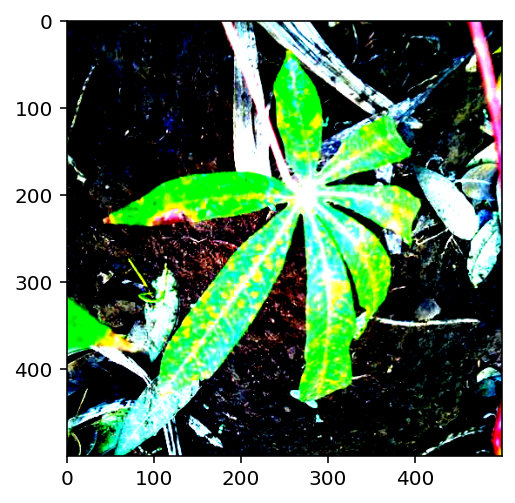

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


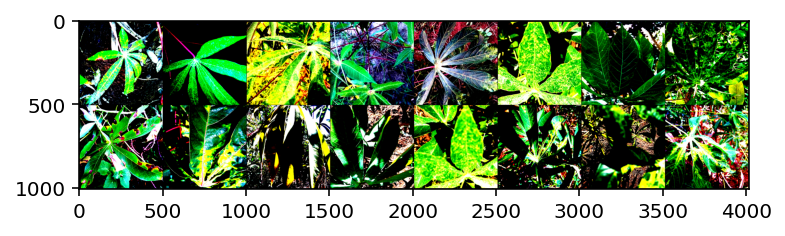

 cbsd  cgm  cmd cbsd  cmd  cgm cbsd  cmd  cbb  cmd cbsd  cbb  cgm  cmd  cmd  cmd
torch.Size([3, 500, 500])


In [16]:
print(images.shape)
#print(class_names[labels[0]])
custom_imshow(images[0])
custom_imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' %class_names[labels[i]] for i in range(images.shape[0])))
print(images[0].shape)

## 모델 구축
### resnet50 이용
[https://github.com/eunhwa99/TIL/blob/master/Machine%20Learning/Algorithm/ResNet-50.md]

In [17]:
model=models.resnet50(pretrained=True)

In [18]:
for param in model.parameters():
    param.requires_grad=False

# Replace the final fully connected layter to suite the problem
model.fc=nn.Sequential(nn.Linear(2048,512), nn.ReLU(), nn.Dropout(0.2), nn.Linear(512,5),nn.LogSoftmax(dim=1))

criterion=nn.NLLLoss()
#optimizer=optim.Adam(model.fc.parameters(), lr=0.003)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.003, momentum=0.9) # weight_decay=5e-4)
model.to(device)    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
epoch_list, train_accuracy_list, test_accuracy_list, train_loss_list, validation_loss_list=[],[],[],[],[]
count=0
for epoch in range(epochs):
    gc.collect()
    torch.cuda.empty_cache()
    train_loss=0
    valid_loss=0
    accuracy=0
    # Training the model
    model.train()
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels=inputs.to(device), labels.to(device)
    
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output=model.forward(inputs)
        # Loss
        loss=criterion(output,labels)
        # Calculate gradients --> backpropagation
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        
        train_loss+=loss.item()*inputs.size(0)
    
    # Evaluating the model
    model.eval()
    
    # not to calculate gradients
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels=inputs.to(device), labels.to(device)
            output=model.forward(inputs)
            valloss=criterion(output, labels)
            valid_loss+=valloss.item()*inputs.size(0)
            
            # model outputs are a LogSoftmax --> calculate real percentages by reversing the log function
            output=torch.exp(output)
            top_p,top_class=output.max(dim=1)
            equals=top_class==labels
            accuracy+=torch.mean(equals.type(torch.FloatTensor)).item()
    
    train_loss=train_loss/len(train_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss=valid_loss/len(test_loader.dataset)
    validation_loss_list.append(valid_loss)
    train_acc=accuracy/len(train_loader)
    train_accuracy_list.append(train_acc)
    test_acc=accuracy/len(test_loader)
    test_accuracy_list.append(test_acc)
    epoch_list.append(epoch)
    print(f'Epoch: {epoch}, Accuracy: {accuracy}, Train loss: {train_loss}, Valid loss: {valid_loss}')

Epoch: 0, Accuracy: 266.6875, Train loss: 0.9665472284907836, Valid loss: 0.7190522922484844
Epoch: 1, Accuracy: 286.8125, Train loss: 0.7333190444925382, Valid loss: 0.5514476698687593
Epoch: 2, Accuracy: 285.125, Train loss: 0.6637404138246048, Valid loss: 0.5495766446184066
Epoch: 3, Accuracy: 291.8125, Train loss: 0.6688809564713879, Valid loss: 0.5108631613020175
Epoch: 4, Accuracy: 293.4375, Train loss: 0.6129203755329489, Valid loss: 0.49826378979136615
Epoch: 5, Accuracy: 286.3125, Train loss: 0.5943763174717295, Valid loss: 0.5530096011755321
Epoch: 6, Accuracy: 299.625, Train loss: 0.568323119526368, Valid loss: 0.45268449155663837
Epoch: 7, Accuracy: 296.375, Train loss: 0.5716615658163856, Valid loss: 0.45928825810024726
Epoch: 8, Accuracy: 290.0625, Train loss: 0.5648004962118208, Valid loss: 0.5035561564282278
Epoch: 9, Accuracy: 296.875, Train loss: 0.5575813332828133, Valid loss: 0.4487427143219337
Epoch: 10, Accuracy: 297.6875, Train loss: 0.5362527800837197, Valid los

KeyboardInterrupt: 

In [20]:
max_train_accuracy = max(train_accuracy_list)
max_test_accuracy = max(test_accuracy_list)
# epoch 중 가장 정확도가 높은 epoch 찾기
epoch_train = epoch_list[train_accuracy_list.index(max_train_accuracy)]
epoch_test = epoch_list[test_accuracy_list.index(max_test_accuracy)]
print(f'Max Accuracy Score: {max_train_accuracy}, Epoch: {epoch_train}')
print(f'Max Accuracy Score: {max_test_accuracy}, Epoch: {epoch_test}')

Max Accuracy Score: 0.8935381355932204, Epoch: 30
Max Accuracy Score: 0.8935381355932204, Epoch: 30


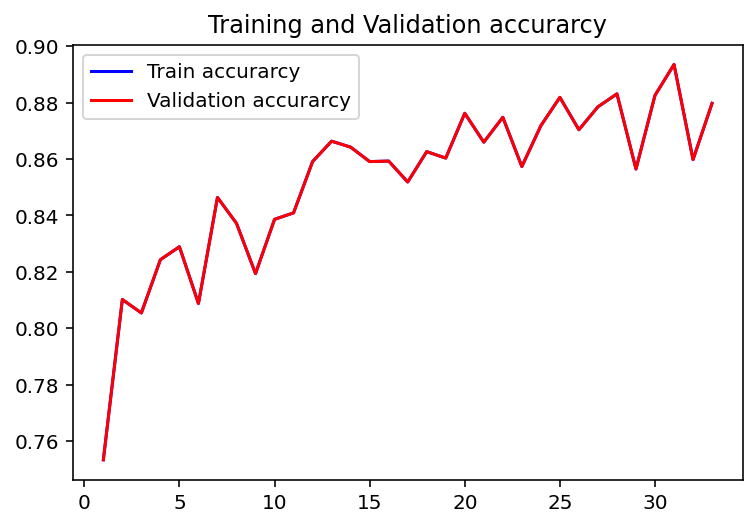

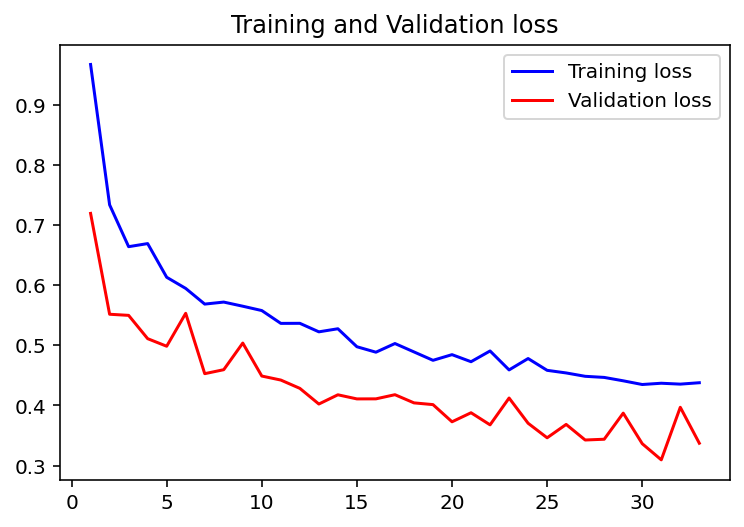

In [21]:
epochs = range(1, len(train_accuracy_list) + 1)
#Train and validation accuracy
plt.plot(epochs, train_accuracy_list, 'b', label='Train accurarcy')
plt.plot(epochs, test_accuracy_list, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend() #범례선 추가(내부에 데이터를 설명하는 범례)

plt.figure() # 새로운 figure를 생성해준다.
#Train and validation loss
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.plot(epochs, validation_loss_list, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show() # 생성된 모든 figure를 보여준다.

In [22]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 테스트 하기

In [ ]:
def process_image(image_dir):
    # PIL Image processing for use in a PyTorch model
    image=Image.open(image_dir)
    preprocess=transforms.Compose([
        transforms.Resize(500),
        transforms.CenterCrop(450),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    # 2D image -> 1D vector
    image=np.expand_dims(image,0) # 배열의 차원을 늘려준다. 0번째 차원의 크기를 늘린다.
    image=torch.from_numpy(image)
    inputs=image.to(device)
    return inputs

In [ ]:
# Using our model to predict the label
def predict(image, model):
    # pass the image through out model
    output=model.forward(image)
    output=torch.exp(output)
    probs, classes=output.max(dim=1)
    return probs.item(), classes.item()

In [ ]:
test_directory='cassava/test/test/0'
predictions, test_image_fileName=[],[]
try:
    test_images=listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image=process_image(f'{test_directory}/{images}')
        top_prob, top_class=predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)
print(len(predictions), len(test_image_fileName))

In [ ]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName}
submission_data_frame = pd.DataFrame(submission_data)

In [ ]:
submission_data_frame.head()

In [ ]:
print("[INFO] Saving Predicition to CSV")
submission_data_frame.to_csv('sample-submission.csv',columns=["Category","Id"], index = False)